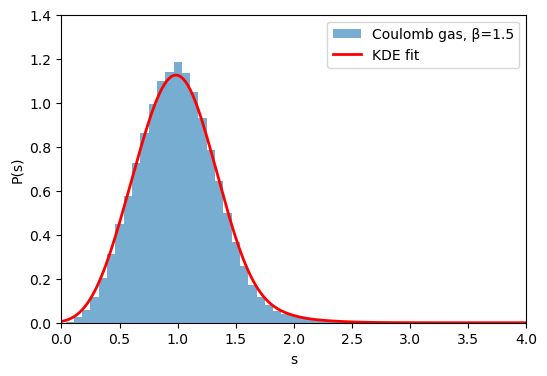

TypeError: save_hdf5() takes 2 positional arguments but 3 were given

In [ ]:
import numpy as np

def coulomb_energy(z:np.ndarray, beta:float) -> float:
    z = z.reshape(-1)
    N = z.size
    E = np.sum(np.abs(z)**2)  # |z_i|^2
    if beta != 0.0:
        diff = z.reshape(N, 1) - z.reshape(1, N)  # pairwise log 斥力项
        mask = ~np.eye(N, dtype=bool)  # only summation i!=j
        E -= 0.5 * beta * np.sum(np.log(np.abs(diff[mask])))
    return E

def metropolis_coulomb(z_init:np.ndarray, beta:float, n_steps:int,
                       step_size=0.3,
                       burn_in=10000,
                       sample_interval=50,
                       rng=None):
    """
    z_init: initial configuration, shape (N,)
    beta: inverse temperature
    n_steps: total number of steps
    step_size: proposal Gaussian step size
    burn_in: number of initial steps to discard
    sample_interval: interval between samples
    returns: list of snapshots, each snapshot is a complex array of shape (N,)
    """
    if rng is None:
        rng = np.random.default_rng()

    z, N = z_init.copy(), z_init.size
    samples = []
    E = coulomb_energy(z, beta)
    for step in range(n_steps):
        # generate a random number
        k = rng.integers(N)
        z_new = z.copy()
        # change one particle position
        delta = rng.normal(scale=step_size) + 1j * rng.normal(scale=step_size)
        z_new[k] += delta
        E_new = coulomb_energy(z_new, beta)
        dE = E_new - E
        # Metropolis criterion
        if dE < 0 or rng.random() < np.exp(-dE):
            z, E = z_new, E_new
        # sampling
        if step > burn_in and (step - burn_in) % sample_interval == 0:
            samples.append(z.copy())
    return samples


def nearest_neighbor_spacings(z:np.ndarray) -> np.ndarray:
    """
    Given a set of complex points z, return the nearest neighbor distance s_i for each point
    """
    z = z.reshape(-1)
    N = z.size
    diff = z.reshape(N, 1) - z.reshape(1, N)
    dist = np.abs(diff)
    # ignore self-distance
    np.fill_diagonal(dist, np.inf)
    s = np.min(dist, axis=1)
    return s

def spacings_from_samples(samples):
    """
    Given a list of snapshots, compute the nearest neighbor spacings and perform a simple unfolding
    (normalize the average spacing to 1)
    """
    all_s = []
    for z in samples:
        s = nearest_neighbor_spacings(z)
        all_s.append(s)
    all_s = np.concatenate(all_s)
    # unfolding: 平均 spacing -> 1
    mean_s = np.mean(all_s)
    all_s /= mean_s
    return all_s


import matplotlib.pyplot as plt

rng = np.random.default_rng()

N = 300  # number of particles
beta = 1.5  # inverse temperature
n_steps = 300000

# initial points: Gaussian distribution
z0 = rng.normal(size=N) + 1j * rng.normal(size=N)

samples = metropolis_coulomb(z0, beta, n_steps,
                             step_size=0.3,
                             burn_in=40000,
                             sample_interval=50,
                             rng=rng)

s_all = spacings_from_samples(samples)

from scipy.stats import gaussian_kde
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(s_all, bins=50, density=True, alpha=0.6, label=f"Coulomb gas, β={beta}")
kde = gaussian_kde(s_all, bw_method=0.3)
s_range = np.linspace(0, 4, 200)
y = kde(s_range)
ax.plot(s_range, y, 'r-', linewidth=2, label='KDE fit')
ax.set_xlim(0, 4)
ax.set_ylim(0, 1.4)
ax.set_xlabel("s")
ax.set_ylabel("P(s)")
ax.legend()
plt.show()

from quante.basicfun import save_hdf5
filename = "gas.h5"
group = f"beta_{beta}"
data = {
    "s_range": s_range,
    "func": y,
}
save_hdf5(filename=filename, group=group, data=data)